## E/Gamma HLT efficiency from NanoAOD using Tag and Probe.

In this tutorial, we explain the basic usage of this package to perform efficiency measurements of single electron triggers using tag and probe.

To setup this package please follow the README in the package's [Github repository](https://github.com/iasonkrom/egamma-tnp). We will first showcase the usage using 2 root files locally and then showcase how the package is meant to be used on a cluster (like LPC or LXPLUS).

Let's start by importing some stuff and setting some plotting parameters. The important things here are `TagNProbe` and `plot_efficiency`. The rest are just for plotting customization.

In [ ]:
import dask_awkward as dak  # This is not required. It's for showcasing purposes
import mplhep as hep
from egamma_tnp import TagNProbe
from egamma_tnp.plot import plot_efficiency
from matplotlib import pyplot as plt

hep.style.use("CMS")
hep.style.use({"font.size": 16})
hep.style.use({"figure.figsize": (6.4, 4.8)})

The main thing that we are gonna use is the `TagNProbe` object. Let's look at it's docstrings.

In [ ]:
help(TagNProbe)

Let's therefore define such an object passing in a list of two local root files, a Pt threshold of 32 and a golden json file path. We must also set `toquery` and `redirect` to `False` because these files are local and we don't want to query `rucio` for those files nor change their `xrootd` redirector.

After that, we need to load those events using the `load_events()` method.

In [ ]:
%%time

tag_n_probe = TagNProbe(
    ["../root_files/Egamma0.root", "../root_files/Egamma1.root"],
    32,
    goldenjson="../json/Cert_Collisions2023_366442_368823_Golden.json",
    toquery=False,
    redirect=False,
)

tag_n_probe.load_events()
tag_n_probe

We can ask from this object to give us the $P_T$ and $\eta$ histograms of the probes that pass trigger matching and all the probes. This is done using the `get_tnp_histograms()` method.

In [ ]:
%%time

(
    hpt_pass,
    hpt_all,
    heta_pass,
    heta_all,
) = tag_n_probe.get_tnp_histograms()

print(f"Passing probes: {hpt_pass.sum(flow=True)}")
print(f"All probes: {hpt_all.sum(flow=True)}")

Wow, why did this run so quickly and why is the number of probes zero? What happened here? Let's look at one of those histograms.

In [ ]:
hpt_pass

It's actually empty yet. The reason for that is that it's actually a dask histogram object that hasn't been filled yet.

In [ ]:
print(type(hpt_pass))
print(hpt_pass.staged_fills())

That means it's actually a dask task graph yet and not a materialized histogram. We can actually visualize this graph!

In [ ]:
hpt_pass.visualize("graph.pdf", optimize_graph=False)

To actually perform the computation and get the materialized histograms (may take time!), we can call `.compute()` on them or do `dask.compute(*histograms)`. Luckily, we provide a shortcut for this when using `get_tnp_histograms()` where we can just pass `compute=True` as an argument. Users can also choose whether they want to get a progress bar and can also choose what dask scheduler they want to use.

In [ ]:
%%time

(
    hpt_pass,
    hpt_all,
    heta_pass,
    heta_all,
) = tag_n_probe.get_tnp_histograms(compute=True, scheduler=None, progress=True)

print(f"Passing probes: {hpt_pass.sum(flow=True)}")
print(f"All probes: {hpt_all.sum(flow=True)}")

In [ ]:
hpt_pass

Now we can actually see a number of passing and all probes and that the histograms are actually materialized. `scheduler=None` will use the default scheduler but other scheduler options are available. More info can be found [here](https://docs.dask.org/en/stable/scheduler-overview.html).

A distributed Client can also be used to perform the computation. Let's do the necessary import. This is how we're also gonna submit jobs to the LPC condor farm.

In [ ]:
from distributed import Client

Then we can just spawn a `Client` to do all the computations (`client=Client()`) or use it as a context manager (`with Client() as client:`). More basic examples of dask client usage can be found [here](https://distributed.dask.org/en/latest/client.html).

In [ ]:
client = Client()

In [ ]:
%%time

(
    hpt_pass,
    hpt_all,
    heta_pass,
    heta_all,
) = tag_n_probe.get_tnp_histograms(compute=True)

print(f"Passing probes: {hpt_pass.sum(flow=True)}")
print(f"All probes: {hpt_all.sum(flow=True)}")

And now that we have our histograms we can plot them.

In [ ]:
hpt_pass.plot1d(label="passing probes", flow="none")
hpt_all.plot1d(label="all probes", flow="none")
plt.xlim(5, 400)
plt.xlabel(r"$P_T$ [GeV]")
plt.ylabel(r"Counts")
plt.legend()
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.show()

In [ ]:
heta_pass.plot1d(label="passing probes", flow="none")
heta_all.plot1d(label="all probes", flow="none")
plt.xlim(-2.5, 2.5)
plt.xlabel(r"$\eta$")
plt.ylabel(r"Counts")
plt.legend()
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.show()

To get the efficiency plots, we will just use the `plot_efficiency` function that we imported earlier.

In [ ]:
help(plot_efficiency)

In [ ]:
plot_efficiency(hpt_pass, hpt_all)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(5, 400)
plt.xlabel(r"$P_T$ [GeV]")
plt.ylabel(r"Efficiency")
plt.xscale("log")
plt.show()

In [ ]:
plot_efficiency(heta_pass, heta_all)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(-2.5, 2.5)
plt.xlabel(r"$\eta$")
plt.ylabel(r"Efficiency")
plt.show()

Now that we've showcased the basic usage locally, let's move into a cluster. For the setup, please consult the README.

Of course the initial imports are required and then we start up a distributed dask `Client`. If you have port-forwarded port 8787 during your ssh login, then you can monitor the progress of your computation using the dask dashboard at http://localhost:8787/.

In [1]:
import mplhep as hep
from egamma_tnp import TagNProbe
from egamma_tnp.plot import plot_efficiency
from matplotlib import pyplot as plt

hep.style.use("CMS")
hep.style.use({"font.size": 16})
hep.style.use({"figure.figsize": (6.4, 4.8)})

/srv/.env/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


We fire up a `Client` and we can also use the condor farm on LPC if we have `lpcjobqueue` installed. For instructions on how to install it, please consult the README.

In [2]:
from distributed import Client

client = Client()

# or

# from distributed import Client
# from lpcjobqueue import LPCCondorCluster

# cluster = LPCCondorCluster(ship_env=True)
# cluster.adapt(minimum=1, maximum=100)
# client = Client(cluster)

# to use the condor farm on LPC
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 28.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39216,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 28.60 GiB
Comm: tcp://127.0.0.1:34660,Total threads: 2
Dashboard: http://127.0.0.1:36647/status,Memory: 5.72 GiB
Nanny: tcp://127.0.0.1:41988,


We now define a `TagNProbe` telling it we want to perform tag and probe over the datasets `"/EGamma0/Run2023C-PromptNanoAODv12_v3-v1/NANOAOD"` and `"EGamma1/Run2023C-PromptNanoAODv12_v3-v1/NANOAOD"`, using again a Pt threshold of 32 (Ele32 trigger).

In [3]:
%%time

tag_n_probe = TagNProbe(
    [
        "/EGamma0/Run2023C-PromptNanoAODv12_v3-v1/NANOAOD",
        "/EGamma1/Run2023C-PromptNanoAODv12_v3-v1/NANOAOD",
    ],
    32,
    goldenjson="../json/Cert_Collisions2023_366442_368823_Golden.json",
    toquery=True,
    redirect=False,
)

tag_n_probe.load_events()
tag_n_probe

Dataset /EGamma0/Run2023C-PromptNanoAODv12_v3-v1/NANOAOD has 22 files

First file of dataset /EGamma0/Run2023C-PromptNanoAODv12_v3-v1/NANOAOD is root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/data/Run2023C/EGamma0/NANOAOD/PromptNanoAODv12_v3-v1/80000/07a23138-6960-4b3a-8ef9-c914eb5da6ab.root

Last file of dataset /EGamma0/Run2023C-PromptNanoAODv12_v3-v1/NANOAOD is root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/data/Run2023C/EGamma0/NANOAOD/PromptNanoAODv12_v3-v1/80000/f3820739-9996-4a32-8662-6f3645008f19.root

Dataset /EGamma1/Run2023C-PromptNanoAODv12_v3-v1/NANOAOD has 24 files

First file of dataset /EGamma1/Run2023C-PromptNanoAODv12_v3-v1/NANOAOD is root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/data/Run2023C/EGamma1/NANOAOD/PromptNanoAODv12_v3-v1/80000/099a180b-12a5-4f11-86c1-1964eb448df8.root

Last file of dataset /EGamma1/Run2023C-PromptNanoAODv12_v3-v1/NANOAOD is root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/data/Run2023C/EGamma1/NANOAOD/PromptNanoAODv12_v3-v1/8

TagNProbe(Events: dask.awkward<from-uproot, npartitions=46>, Number of files: 46, Golden JSON: ../json/Cert_Collisions2023_366442_368823_Golden.json)

The rest from now on is exactly the same.

In [4]:
%%time

(
    hpt_pass,
    hpt_all,
    heta_pass,
    heta_all,
) = tag_n_probe.get_tnp_histograms(compute=True, scheduler=None, progress=True)

print(f"Passing probes: {hpt_pass.sum(flow=True)}")
print(f"All probes: {hpt_all.sum(flow=True)}")

[########################################] | 100% Completed | 308.19 ms
Passing probes: 634217.0
All probes: 743324.0
CPU times: user 23.7 s, sys: 2.16 s, total: 25.9 s
Wall time: 2min 53s


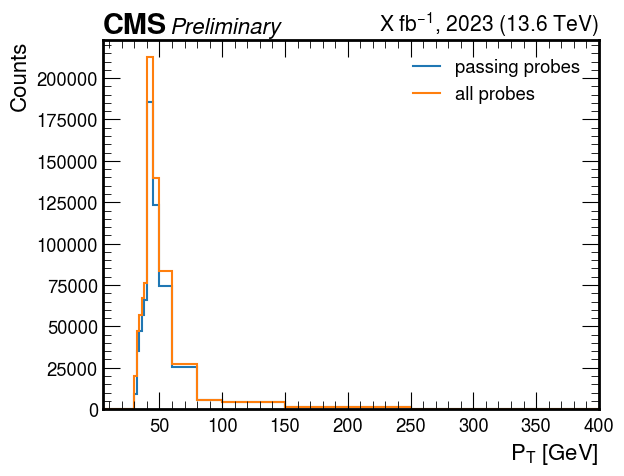

In [5]:
hpt_pass.plot1d(label="passing probes", flow="none")
hpt_all.plot1d(label="all probes", flow="none")
plt.xlim(5, 400)
plt.xlabel(r"$P_T$ [GeV]")
plt.ylabel(r"Counts")
plt.legend()
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.show()

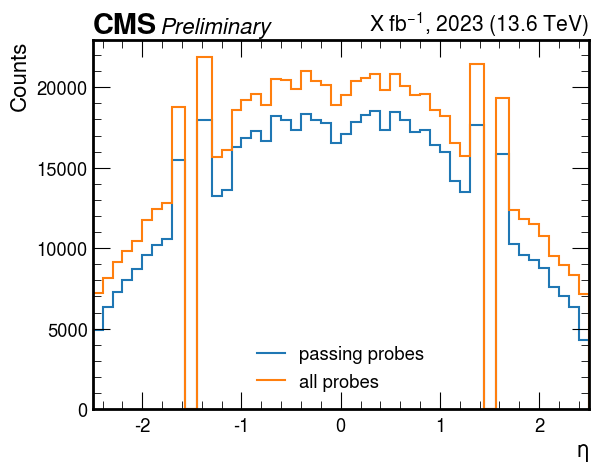

In [6]:
heta_pass.plot1d(label="passing probes", flow="none")
heta_all.plot1d(label="all probes", flow="none")
plt.xlim(-2.5, 2.5)
plt.xlabel(r"$\eta$")
plt.ylabel(r"Counts")
plt.legend()
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.show()

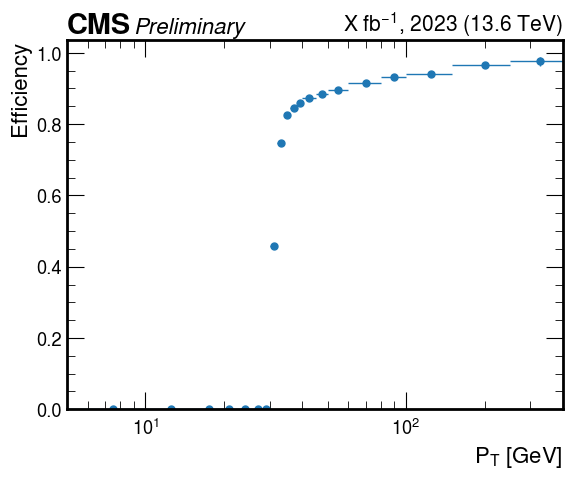

In [7]:
plot_efficiency(hpt_pass, hpt_all)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(5, 400)
plt.xlabel(r"$P_T$ [GeV]")
plt.ylabel(r"Efficiency")
plt.xscale("log")
plt.show()

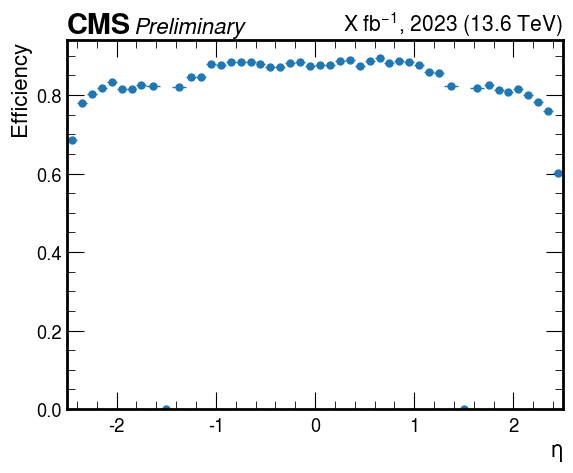

In [8]:
plot_efficiency(heta_pass, heta_all)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(-2.5, 2.5)
plt.xlabel(r"$\eta$")
plt.ylabel(r"Efficiency")
plt.show()

And we have our final efficiency plots for `Run2023C -v3`.